In [1]:
from icecube import icetray, dataio, dataclasses, simclasses

import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# change defaults for nicer plotting
plt.rcParams.update({'font.size': 20})
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

mpl.rcParams['hist.bins'] = 100
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['patch.linewidth'] = 2.5
mpl.rcParams['grid.alpha'] = 0.2

__reading from file__
-------------------------------

here I'm readig from 1 file; 
you can add file loop later.

In [3]:
fr_arr = []; mctree_arr = []

pth = 'MCdata/83.i3.bz2' # path to i3 file
with dataio.I3File('MCdata/83.i3.bz2') as f:
    for fr in f:
        if f.stream.id != 'Q': continue
        fr_arr.append( fr )
        mctree_arr.append( fr['I3MCTree'] )

some functions to use

In [4]:
def path_len(pos1, pos2):                                  
    return np.sqrt((pos2.x-pos1.x)**2+(pos2.y-pos1.y)**2+(pos2.z-pos1.z)**2)

def path_len_mmc(mmc_tr):                                  
    return np.sqrt((mmc_tr.xf-mmc_tr.xi)**2+(mmc_tr.yf-mmc_tr.yi)**2+(mmc_tr.zf-mmc_tr.zi)**2)

reading some variables relevant to our muons propagation

In [5]:
mmc_Ei = []; mmc_Ef = []
mmc_Elost = []
mmc_path = []

for fr in fr_arr: 
    for i in range(len(fr['MMCTrackList'])):
        mmc_tr = fr['MMCTrackList'][i]                              
    
        mmc_Ei.append( mmc_tr.Ei / icetray.I3Units.GeV )
        mmc_Ef.append( mmc_tr.Ef / icetray.I3Units.GeV )
        mmc_Elost.append( mmc_tr.Elost / icetray.I3Units.GeV )
        mmc_path.append( path_len_mmc(mmc_tr) )

mmc_Ei = np.array(mmc_Ei); mmc_Ef = np.array(mmc_Ef)
mmc_Elost = np.array(mmc_Elost)
mmc_path = np.array(mmc_path)

# Muon selection

__Energy range__
--------------------------

we want MIP muons. First, let's cut these with energies much bigger than 'MIP region'.

From `https://edoc.hu-berlin.de/bitstream/handle/18452/15655/Kowalski.pdf?sequence=1&isAllowed=y`: I'll take 500 GeV as a point, where radiative losses are starting to dominate.

- _this is just my example, you should check it and, maybe, try to figure out better threshold!_

let's see how our muon energy is distributed.

/home/maria/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


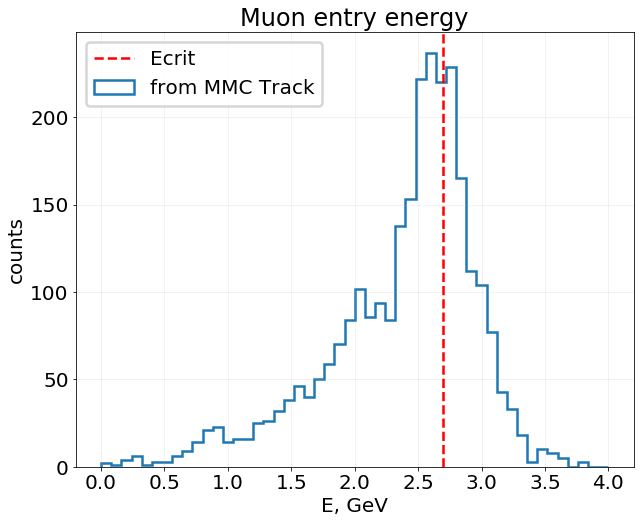

In [6]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon entry energy')
ax.set_ylabel('counts')
ax.set_xlabel('E, GeV')

plt.hist(np.log10(mmc_Ei), 50, range=[0.,4.], 
         histtype='step', label='from MMC Track') 

ax.axvline(np.log10(500.), c='r', linestyle='--', label='Ecrit')

ax.grid()
plt.legend(loc=2)
plt.show()

cut them!

In [7]:
en_cut = (mmc_Ei<500.)

check if we did it correctly

/home/maria/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


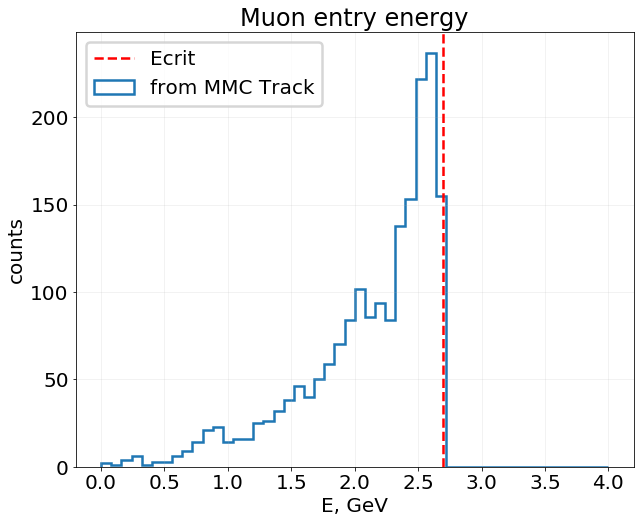

In [8]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon entry energy')
ax.set_ylabel('counts')
ax.set_xlabel('E, GeV')

plt.hist(np.log10(mmc_Ei[en_cut]), 50, range=[0.,4.], 
         histtype='step', label='from MMC Track') 

ax.axvline(np.log10(500.), c='r', linestyle='--', label='Ecrit')

ax.grid()
plt.legend(loc=2)
plt.show()

__Stochastic energy losses__
-------------------------------------------

we don't want to have muons with stochastic energy losses in our sample.

Let's see how much will remain if we'll remove all muons with stochastics.

In [9]:
n_stochastics = []

for fr in fr_arr: 
    for i in range(len(fr['MMCTrackList'])):
        mu = fr['MMCTrackList'][i].GetI3Particle()                              
        mctree = fr['I3MCTree']
    
        daughters = mctree.get_daughters(mu)
        n_stochastics.append( len(daughters) )
        
n_stochastics = np.array(n_stochastics)

I'm applying our cut on muon energy here. (it's good to check weather our arrays are sorted the same way first)

In [10]:
len(n_stochastics) == len(en_cut)

True

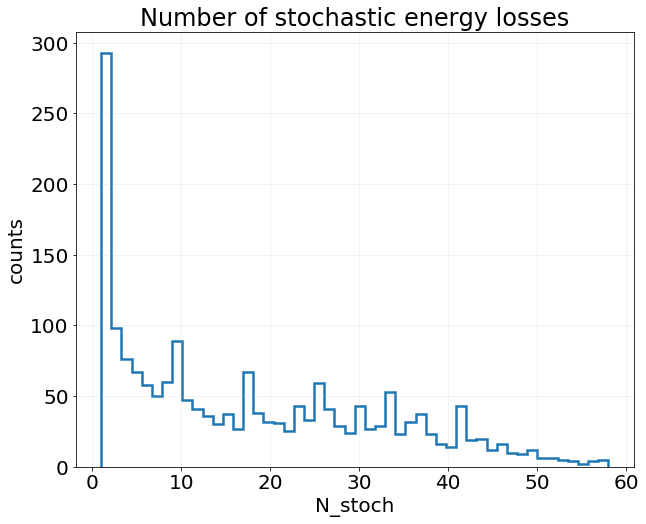

In [11]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Number of stochastic energy losses')
ax.set_ylabel('counts')
ax.set_xlabel('N_stoch')

plt.hist(n_stochastics[en_cut], 50, histtype='step') 

ax.grid()
plt.show()

let's select only muons with no stochastic losses.

__(!)__ Keep in mind that __there is no clear boundary between continious and stochastic losses__. They are distinguished by an arbitrary energy cut, which is set during propagation (of course it's not complitely arbitrary, it's selected in some resonable energy range). 

So it's possible that it would be actually better to keep some muons with low-energy stochastic losses (e.g for statistic). This way we will effictively increase energy cut for stochastics. Up to you to decide if you want this or not.

__Here I'm selecting only muons with 0 stochastic losses as an example.__

In [12]:
nstoch_cut = (n_stochastics[en_cut] == 0)

how many did we ended with?

In [13]:
print 'N muons after energy cut)', len(n_stochastics[en_cut])
print 'N muons after energy cut + 0 stochastics cut', len(n_stochastics[en_cut][nstoch_cut])

perc = (1. - float(len(n_stochastics[en_cut][nstoch_cut]))/float(len(n_stochastics[en_cut])))*100.
print '% of muons cut by "max stochastic en. loss cut"', perc, '%'

N muons after energy cut) 1901
N muons after energy cut + 0 stochastics cut 0
% of muons cut by "max stochastic en. loss cut" 100.0 %


_oops, there are zero of these!_

let's try to store maximum energy for stochastics and cut on this (you can also try sum of daughters energy).

In [14]:
max_stoch_energy = []

for fr in fr_arr: 
    for i in range(len(fr['MMCTrackList'])):
        mu = fr['MMCTrackList'][i].GetI3Particle()                              
        mctree = fr['I3MCTree']
    
        daughters = mctree.get_daughters(mu)
        en = []
        for d in daughters:
            en.append(d.energy)
            # this is a primitive way to store it 
            # (for nucl interactions you should probably also store their daughter energy)
        
        max_stoch_energy.append( max(en) )
        
max_stoch_energy = np.array(max_stoch_energy)

I'm applying our cut on muon energy here. (it's good to check weather our arrays are sorted the same way first)

In [15]:
len(max_stoch_energy) == len(en_cut)

True

/home/maria/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


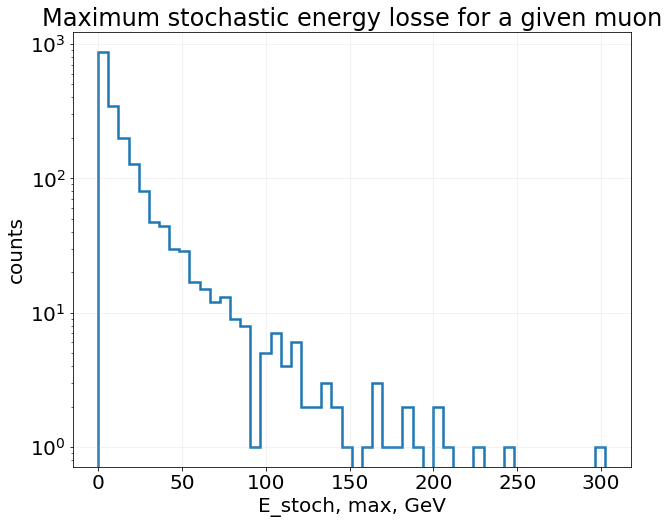

In [16]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Maximum stochastic energy losse for a given muon')
ax.set_ylabel('counts')
ax.set_xlabel('E_stoch, max, GeV')
ax.set_yscale('log')

plt.hist(max_stoch_energy[en_cut], 50, histtype='step') 

ax.grid()
plt.show()

__As an example I'm cutting on max stochastic energy loss <= 1 GeV (arbitrary)__

You shold try to choose a better value

In [17]:
max_sthoc_en_cut = (max_stoch_energy[en_cut] <= 1.)

how many did we ended with?

In [18]:
print 'N muons after energy cut', len(max_stoch_energy[en_cut])
print 'N muons after energy cut + max stochastic en. loss cut', len(max_stoch_energy[en_cut][max_sthoc_en_cut])

perc = (1. - float(len(max_stoch_energy[en_cut][max_sthoc_en_cut]))/float(len(max_stoch_energy[en_cut])))*100.
print '% of muons cut by "max stochastic en. loss cut"', perc, '%'

N muons after energy cut 1901
N muons after energy cut + max stochastic en. loss cut 307
% of muons cut by "max stochastic en. loss cut" 83.8506049448 %


__Now you can continue selection by adding other cuts and improving mine!__
------------------------------------------------------------------------------------------------------------------